In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5


In [3]:
f(3)

20

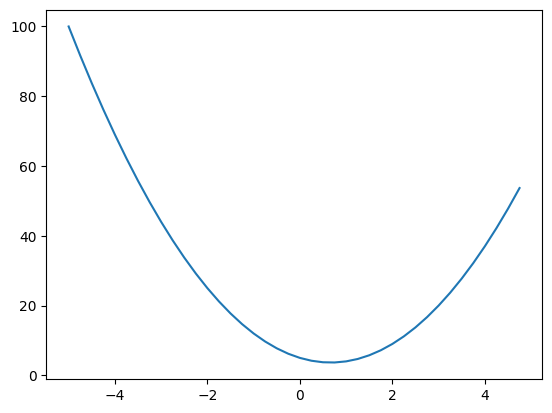

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs,ys)

In [5]:
h = 0.01
x = -3.0
(f(x+h)-f(x))/h

-21.9699999999996

In [6]:
a = 2.0
b = -3.0
c = 10.0
d = a * b + c

print(d)

4.0


In [7]:
h = 0.001
a = 2.0
b = -3.0
c = 10.0
d1 = a * b + c

c += h
d2 = a * b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0009999999999994
slope 0.9999999999994458


In [49]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [9]:
a = Value(2.0, label = 'a')
b = Value(-3.0, label = 'b')
c = Value(10.0, label = 'c')
e = a*b; e.label = 'e'
d = e+c; d.label = 'd'
f = Value(-2.0, label = 'f')
L = d*f; L.label = 'L'
L

Value(data = -8.0)

In [10]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [11]:
a.grad = 6.0
b.grad = -4.0
e.grad = -2.0
c.grad = -2.0
d.grad = -2.0
f.grad = 4.0
L.grad = 1.0

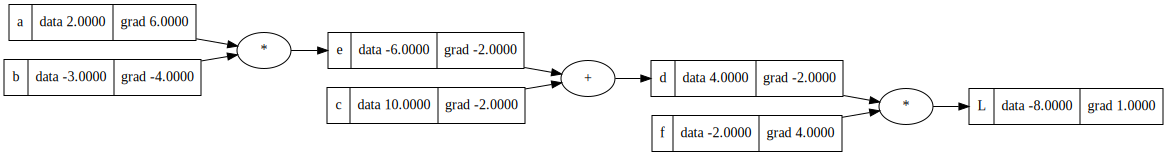

In [12]:
draw_dot(L)

In [13]:


def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data + h
  
  print((L2 - L1)/h)
  
lol()



1.000000000000334


In [14]:
eta = 0.01
a.data += eta*a.grad; a.label = a
b.data += eta*b.grad; b.label = b
c.data += eta*c.grad; c.label = c
f.data += eta*f.grad; f.label = f

e = a*b
d = e + c 
L = d * f; L.label = 'L'






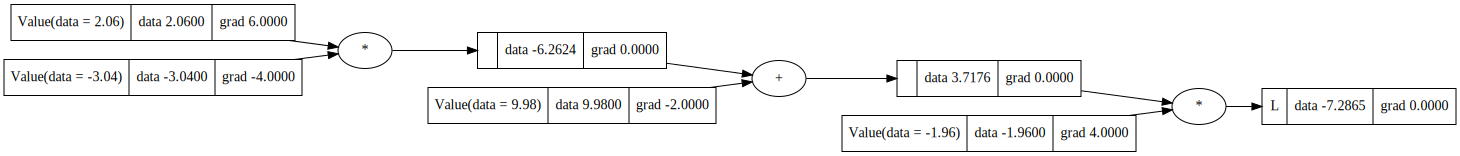

In [15]:
draw_dot(L)


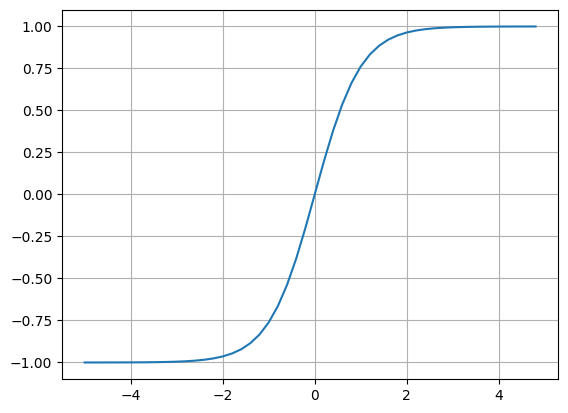

In [16]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [26]:
# INPUTS  x1 x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1 w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o  = n.tanh(); o.label = 'o'

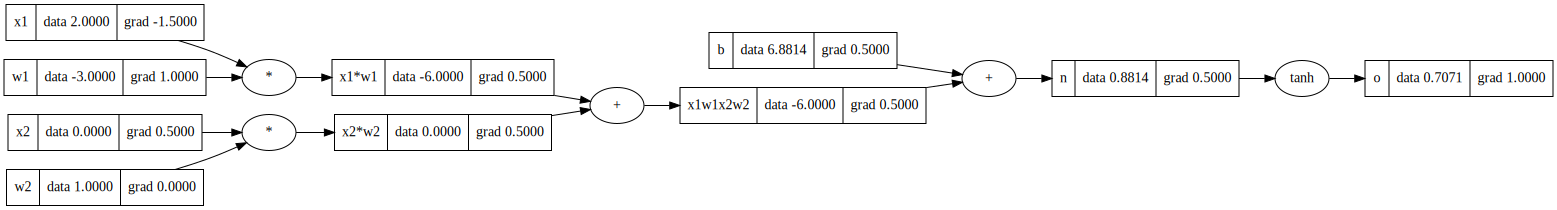

In [27]:
o.backward()
draw_dot(o)

In [19]:
# ## Manually calculating gradients

# # o.grad = 1.0
# # n.grad = 0.5
# # x1w1x2w2.grad = 0.5
# # b.grad = 0.5
# # x1w1.grad = 0.5
# # x2w2.grad = 0.5
# # x2.grad = w2.data * x2w2.grad
# # w2.grad = x2.data * x2w2.grad

# # x1.grad = w1.data * x1w1.grad
# # w1.grad = x1.data * x1w1.grad


# ## automatically calculating gradients 
# o.grad = 1
# o._backward()
# n._backward()
# b._backward()
# x1w1x2w2._backward()
# x1w1._backward()
# x2w2._backward()
# x1._backward()
# w1._backward()
# x2._backward()
# w2._backward()



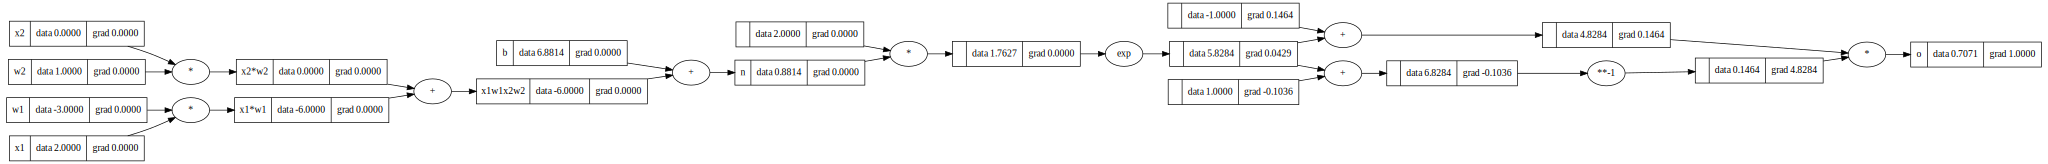

In [24]:
# INPUTS  x1 x2
x1 = Value(2.0,label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1 w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.8813735870195432, label = 'b')
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2 ; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2*n).exp()
o = (e-1)/(e+1)
o.label = 'o'
o.backward()
draw_dot(o)

In [31]:
import torch

x1 = torch.Tensor([2.0]).double()                    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()                   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                    ; w2.requires_grad = True
b = torch.Tensor([6.9913735870195432]).double()      ; b.requires_grad = True
n = x1*w1 + x2*w2                           
o = torch.tanh(n)                          



print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

-0.9999877116507956
---
x2 2.4576547405286142e-05
w2 0.0
x1 -7.372964221585843e-05
w1 4.9153094810572284e-05


In [133]:
import random

class Neuron:
  
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    
    def __call__(self, x):
    # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]

class Layer:


    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

x = [2.0, 3.0, -1]
n = MLP(3,[4,4,1])
n(x)




Value(data=-0.9607387114512178)

In [134]:
len(n.parameters())

41

In [135]:
xs = [
    [2.0,3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0,-1.0, 1.0]


In [139]:
for k in range(200):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    for p in n.parameters():
        p.grad = 0.0


    loss.backward()
    for p in n.parameters():
        p.data += -0.01 * p.grad
    
    print(k, loss.data)



0 0.02156807581108966
1 0.02143757229027564
2 0.02130849419219141
3 0.02118081906953531
4 0.02105452493618557
5 0.020929590255528676
6 0.0208059939291383
7 0.020683715285792298
8 0.020562734070817185
9 0.02044303043574692
10 0.02032458492828744
11 0.02020737848257465
12 0.020091392409716982
13 0.01997660838861292
14 0.019863008457033232
15 0.01975057500296105
16 0.01963929075617858
17 0.019529138780094803
18 0.019420102463804417
19 0.019312165514371676
20 0.019205311949330638
21 0.01909952608939585
22 0.018994792551375775
23 0.018891096241283503
24 0.018788422347636807
25 0.018686756334943246
26 0.018586083937363194
27 0.018486391152545797
28 0.018387664235631943
29 0.01828988969341967
30 0.01819305427868608
31 0.018097144984661834
32 0.018002149039652315
33 0.01790805390180251
34 0.017814847253999497
35 0.017722516998909726
36 0.017631051254146074
37 0.01754043834756118
38 0.017450666812663204
39 0.017361725384150255
40 0.017273602993559848
41 0.01718628876503018
42 0.0170997720111695

In [140]:
ypred

[Value(data=0.9558635050766061),
 Value(data=-0.9634802047175145),
 Value(data=-0.9414770594683393),
 Value(data=0.949181613188436)]